# Bangkok's Metro (BTS, MRT, ARL) and Surrounding Venues

#### By Arrart Kongtaln

## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Bangkok is the capital city of Thailand, and has a population of over 8 million people. The surrounding area, the Bangkok Metropolitan Region, is home to more than 14 million citizens, myself included.  Thailand's Bangkok Metropolitan Region has **3** main urban rail transit systems, the **BTS** (Bangkok mass Transit System or Skytrain), the **MRT** (Metropolitan Rapid Transit), and the **ARL** (Airport Rail Link).
There are currently 111 stations in operation (we will use 109 locations, as Siam station is listed on both BTS lines, and Tao Poon station is listed on two MRT lines):

  * 49 BTS Skytrain stations (36 on the Sukhumvit Line and 13 on the Silom Line, with Siam being an interchange station between the two lines)
  * 54 MRT stations (38 on the Blue Line and 16 on the Purple Line, with Tao Poon station being an interchange between the two lines)
  * 8 Airport Rail Link stations

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The combined average ridership of all 3 transit systems is more than 1.28 million people per day. When people look to rent or buy a residence in or near downtown Bangkok, places near a metro station are usually more attractive than those farther away from the Skytrain or MRT. The focus of this data science project is to look at the kinds of venues surrounding the metro stations and classify them based on the types of venues near a station the most, as well as taking into consideration the geographic location of the station. This report can be useful to people searching for a new home and wanting to know more about an area, or giving an answer to a more common question of deciding where to go to have lunch, or even city planners can use it as a brief summary of the current state of the '*Mass Rapid Transit Master Plan in Bangkok Metropolitan Region*' (or M-Map), among other possible creative applications.

## Data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The final dataframe used for the data analysis contains 107 rows of Bangkok's metro stations' data (the stations 'Bang Pho' and 'Sirindhorn' were recently completed at the time, and did not yet yield location query results from Google's Geocoding API, and were not used). The list of all the metro (**BTS**, **MRT**, **ARL**) stations we used were retrieved from the *Wikipedia* page (as of May 28, 2020) https://en.wikipedia.org/wiki/List_of_rapid_transit_stations_in_Bangkok .

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We clean this data by removing the 'Photo' column, as it does not contain any data relevant to this project. We also handle cases of station duplication as shortly explained in the introduction (more information is provided in the following steps) with stations 'Tao Poon' and 'Siam', by formatting values to remove ambiguity in the columns 'Station Code', 'English Station Name', and 'Line(s)' for each station row so that there is only one value/name in a cell. The last bit of data cleaning is to remove extra information from some cells in the the 'English Station Name' column, where some names have parentheses in them, with the format of '(RTGS: *alternate_spelling*)'. RTGS is the acronym for the 'Royal Thai General System of Transcription', which is an alternate way to spell names in English. However, for our purposes, we need just the name with the common spelling (before the parentheses), and we also remove from the 'Phraek Sa' station row, the alternate spelling string: 'RTGS: Phraekkasa'.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we add latitude and longitude coordinates (as well as the Plus Code if any exist) to each row, by looping through the whole list and creating custom Google Geocoding API queries for each row from their cell values. We then save the dataframe into a .csv file, so that we can use it for repeated testing and data classification, without having to call the Google API each time.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Using the coordinates we got from querying with the Google API, we can query locations and any nearby venues with the Foursquare Places API. We query each station's location and collect the number of venues, sorted by the top-level categories available from the Foursquare API. We can then classify each station based on the top categories of the total number of nearby venues around a station. Clusters of station locations and their surrounding areas can then be marked on a map of Bangkok and inform users about that part of the city.

#### Getting the list of stations and their geographical coordinates

Load your Google API key into the variable, G_API_key, to be used to query location information from the Google search engine.
(For more information on how to setup an account, visit https://developers.google.com/maps/documentation/javascript/get-api-key)
(Important : Enable the 'Geocoding API' for your key in the Google Cloud Platform Console.)

In [1]:
import json

id_keys = json.load(open('credentials.json'))
G_API_key = id_keys['GoogleAPI_Key']

Next, you might need to install the *lxml* Python package (if you do not have it already) with the code below for Jupyter Notebooks (the library is needed for reading data from a webpage in the next step).

In [2]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} lxml

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         125 KB
    certifi-2020.4.5.1         |           py36_0         155 KB
    libxslt-1.1.33             |       h7d1a2b0_0         426 KB
    lxml-4.5.0                 |   py36hefd8a0e_0         1.4 MB
    openssl-1.1.1g             |       h7b6447c_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         4.6 MB

The following NEW packages will be INSTALLED:

  libxslt            pkgs/main/linux-64::libxslt-1.1.33-h7d1a2b0_0
  lxml               pkgs/main/linux-64::lxml-4.5.0-py36hefd8a0e_0

The following packages will be SUPERSEDED by a higher-priority channel:



As of May 28, 2020, Wikipedia provides data on the city of Bangkok's metro (BTS, MRT, ARL), and you can use the following code to retrieve the list of station names :

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

raw_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_rapid_transit_stations_in_Bangkok')[1]
raw_df.head()

Code    Station name              Line(s) Photo               Open  \
   Code         English         Thai Line(s) Photo               Open   
0    N5             Ari       อารีย์     BTS   NaN    5 December 1999   
1    E4            Asok         อโศก     BTS   NaN    5 December 1999   
2    A3  Ban Thap Chang  บ้านทับช้าง     ARL   NaN     23 August 2010   
3   E10       Bang Chak       บางจาก     BTS   NaN     12 August 2011   
4  BL37       Bang Khae        บางแค     MRT   NaN  21 September 2019   

       Transfer to  
       Transfer to  
0              NaN  
1  MRT : Sukhumvit  
2              NaN  
3              NaN  
4              NaN

The table column headers need to be combined into a single row. Use the code below to merge the column headers :

In [4]:
raw_df.columns = raw_df.columns.map(' : '.join)
raw_df.head()

,Code : Code,Station name : English,Station name : Thai,Line(s) : Line(s),Photo : Photo,Open : Open,Transfer to : Transfer to
0,N5,Ari,อารีย์,BTS,NaN,5 December 1999,NaN
1,E4,Asok,อโศก,BTS,NaN,5 December 1999,MRT : Sukhumvit
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,NaN,23 August 2010,NaN
3,E10,Bang Chak,บางจาก,BTS,NaN,12 August 2011,NaN
4,BL37,Bang Khae,บางแค,MRT,NaN,21 September 2019,NaN


We will rename the column names, so that they are more clear, and also remove the 'Photo' column, then display all the rows :

In [5]:
pd.set_option('display.max_rows', None)
column_names = ['Station Code' ,'English Station Name' ,'Thai Station Name' ,'Line(s)' ,'Photo' ,'First Opened' ,'Has Transfer To']
raw_df.columns = column_names
raw_df = raw_df.drop('Photo', 1)
column_names.remove('Photo')
raw_df

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN
1,E4,Asok,อโศก,BTS,5 December 1999,MRT : Sukhumvit
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,23 August 2010,NaN
3,E10,Bang Chak,บางจาก,BTS,12 August 2011,NaN
4,BL37,Bang Khae,บางแค,MRT,21 September 2019,NaN
5,BL04,Bang Khun Non,บางขุนนนท์,MRT,23 December 2019,MRT (planned) SRT : Charansanitwong (planned)
6,PP10,Bang Krasor(RTGS: Bang Kraso),บางกระสอ,MRT,12 August 2016,NaN
7,E13,Bang Na,บางนา,BTS,12 August 2011,NaN
8,BL08,Bang O,บางอ้อ,MRT,4 December 2019,NaN
9,BL33,Bang Phai,บางไผ่,MRT,24 August 2019,NaN


Take a look at the row with ID : 97 using the code below :

In [6]:
raw_df.loc[[97]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
97,PP16 ( MRT )BL10 ( MRT ),Tao Poon(RTGS: Tao Pun),เตาปูน,MRT MRT,6 August 2016 ( MRT )11 August 2017 ( MRT ),NaN


This particular station belongs to both the MRT Purple Line and the MRT Blue Line. However, we only need to query the location (Tao Poon) once, so we will keep data on just the Purple Line as its construction was finished first, and we will note the Blue Line as a transfer connection in the last column.

In [7]:
raw_df.loc[97, 'Station Code'] = 'PP16'
raw_df.loc[97, 'Line(s)'] = 'MRT'
raw_df.loc[97, 'First Opened'] = '6 August 2016'
raw_df.loc[97, 'Has Transfer To'] = 'MRT:Tao Poon(BL10)'

raw_df.loc[[97]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
97,PP16,Tao Poon(RTGS: Tao Pun),เตาปูน,MRT,6 August 2016,MRT:Tao Poon(BL10)


Take a look at the row with ID : 89 using the code below :

In [8]:
raw_df.loc[[89]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
89,CEN,Siam(RTGS: Sayam),สยาม,BTS BTS,5 December 1999,BTS (planned)


This station belongs to both the BTS Sukhumvit Line and the BTS Silom Line. The data pulled from the Wikipedia table printed BTS twice. We will change this to just 'BTS' for the 'Line(s)' column :

In [9]:
raw_df.loc[89, 'Line(s)'] = 'BTS'

raw_df.loc[[89]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
89,CEN,Siam(RTGS: Sayam),สยาม,BTS,5 December 1999,BTS (planned)


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The final issue with the data we need to solve before using it to query the location information, is that in the 'English Station Name' column, some names have parentheses in them, with the format of '(RTGS: _alternate_spelling_)'. RTGS is the acronym for the 'Royal Thai General System of Transcription', which is an alternate way to spell names in English. However, for our purposes, we need just the name with the common spelling (before the parentheses), and we will clean the data in this column using the code below :

In [10]:
to_be_formatted = raw_df[['English Station Name']]

for i, row in to_be_formatted.iterrows():
    idx_of_parenthesis = row[0].find('(')
    if (idx_of_parenthesis >= 0) and (idx_of_parenthesis < len(row[0])):
        eng_name = row[0][:idx_of_parenthesis]
        raw_df.loc[i, 'English Station Name'] = eng_name
        

raw_df

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN
1,E4,Asok,อโศก,BTS,5 December 1999,MRT : Sukhumvit
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,23 August 2010,NaN
3,E10,Bang Chak,บางจาก,BTS,12 August 2011,NaN
4,BL37,Bang Khae,บางแค,MRT,21 September 2019,NaN
5,BL04,Bang Khun Non,บางขุนนนท์,MRT,23 December 2019,MRT (planned) SRT : Charansanitwong (planned)
6,PP10,Bang Krasor,บางกระสอ,MRT,12 August 2016,NaN
7,E13,Bang Na,บางนา,BTS,12 August 2011,NaN
8,BL08,Bang O,บางอ้อ,MRT,4 December 2019,NaN
9,BL33,Bang Phai,บางไผ่,MRT,24 August 2019,NaN


One row seems to still contain the 'RTGS:' format :

In [16]:
raw_df.loc[[60]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
60,E21,Phraek SaRTGS: Phraekkasa,แพรกษา,BTS,6 December 2018,NaN


Let's keep only the common spelling for the English name :

In [17]:
raw_df.loc[60, 'English Station Name'] = 'Phraek Sa'

raw_df.loc[[60]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
60,E21,Phraek Sa,แพรกษา,BTS,6 December 2018,NaN


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The style of coding with dataframes in the *pandas* library does not encourage both iteration over rows while updating them at the same time, so we will create another smaller dataframe, the coordinates dataframe, to keep the query results, then merge both dataframes together into the complete dataframe for our project :

In [18]:
coord_df = raw_df.drop([col for col in column_names if col != 'Station Code'], 1)
coord_df['Plus Code'] = ''
coord_df['Latitude'] = np.nan
coord_df['Longitude'] = np.nan
coord_df.head()

,Station Code,Plus Code,Latitude,Longitude
0,N5,,NaN,NaN
1,E4,,NaN,NaN
2,A3,,NaN,NaN
3,E10,,NaN,NaN
4,BL37,,NaN,NaN


We create a function *insert2coord* to help update the new dataframe above, with values from querying the Google search engine :

In [19]:
def insert2coord(sta_code, pl_code, ll_coords):
    coord_df.loc[coord_df['Station Code'] == sta_code, 'Plus Code'] = pl_code
    coord_df.loc[coord_df['Station Code'] == sta_code, 'Latitude'] = ll_coords['lat']
    coord_df.loc[coord_df['Station Code'] == sta_code, 'Longitude'] = ll_coords['lng']
    return

Let's look at the first row in the first dataframe, and see what data we can use to query the coordinates with :

In [20]:
raw_df.loc[[0]]

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We want to get the longitude and latitude from the Google Geocoding API (https://developers.google.com/maps/documentation/geocoding/intro#geocoding) and we will use the **json** outputFormat with the **address** and **components** filtering parameters, with our **API key** being the last ingredient in the query. In the **address** part, spaces in the name of a place need to be changed to a '+' plus sign. For the **components** part, we use the *administrative_area:bangkok* and *country:TH* (separated by an |) to help narrow down the search to just the Bangkok administrative area in Thailand. The output from the query will be a json text. The values we want will be contained in the 'results' part, and we can use the index values of "[0]['geometry']['location']", which will return a tuple containing the (Latitude, Longitude) as shown in the code below. We will also get the 'Plus Code' of the location, using the index value of "[0]['plus_code']['global_code']" (you can learn more about Plus Codes here : https://plus.codes/).

In [21]:
import requests

search_url = "https://maps.googleapis.com/maps/api/geocode/json?address=BTS+Ari&components=administrative_area:bangkok|country:TH&key=" +G_API_key
search_req = requests.get(search_url)
search_json = search_req.json()

if (not search_json['results']) :
    longlats = {
              "lat": "Not Available",
              "lng": "Not Available"
                }
    plus_code = "Not Available"

else :
    print(search_json)

    longlats = search_json['results'][0]['geometry']['location']
    
    if 'plus_code' in search_json['results'][0].keys():
        plus_code = search_json['results'][0]['plus_code']['global_code']
    else :
        plus_code = ''

    if (len(plus_code) == 0):
        plus_code = "Not Available"

print("plus_code:" +plus_code)
print(longlats)

{'results': [{'access_points': [], 'address_components': [{'long_name': '1215', 'short_name': '1215', 'types': ['street_number']}, {'long_name': 'Phahonyothin Alley', 'short_name': 'Phahonyothin Alley', 'types': ['route']}, {'long_name': 'Khwaeng Samsen Nai', 'short_name': 'Khwaeng Samsen Nai', 'types': ['political', 'sublocality', 'sublocality_level_2']}, {'long_name': 'Khet Phaya Thai', 'short_name': 'Khet Phaya Thai', 'types': ['political', 'sublocality', 'sublocality_level_1']}, {'long_name': 'Krung Thep Maha Nakhon', 'short_name': 'Krung Thep Maha Nakhon', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Thailand', 'short_name': 'TH', 'types': ['country', 'political']}, {'long_name': '10400', 'short_name': '10400', 'types': ['postal_code']}], 'formatted_address': '1215 Phahonyothin Alley, Khwaeng Samsen Nai, Khet Phaya Thai, Krung Thep Maha Nakhon 10400, Thailand', 'geometry': {'location': {'lat': 13.7796944, 'lng': 100.544625}, 'location_type': 'ROOFTOP', 'v

Now that we know the above code works, we can create a **for** loop to iterate over the **raw_df** dataframe and update rows in the **coord_df** dataframe. We then preview the results using the .head() dataframe function.

In [22]:
for index, row in raw_df.iterrows():
    print("Querying: " +row[3] +" -'" +row[1] +"'")
    place_name = row[1].replace(" ", "+")
    search_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}+{}".format(row[3], place_name)
    search_url += "&components=administrative_area:bangkok|country:TH&key=" +G_API_key
    
    #print("search_url:" +search_url)
    
    search_req = requests.get(search_url)
    search_json = search_req.json()
    
    if (not search_json['results']) :
        longlats = {
                  "lat": "Not Available",
                  "lng": "Not Available"
                    }
        plus_code = "Not Available"
        
    else :
        #print(search_json)

        longlats = search_json['results'][0]['geometry']['location']
        
        if 'plus_code' in search_json['results'][0].keys():
            plus_code = search_json['results'][0]['plus_code']['global_code']
        else :
            plus_code = ''

        if (len(plus_code) == 0):
            plus_code = "Not Available"

    
    insert2coord(row[0], plus_code, longlats)
    print("Dataframe updated.")

coord_df.head()

Querying: BTS -'Ari'
Dataframe updated.
Querying: BTS -'Asok'
Dataframe updated.
Querying: ARL -'Ban Thap Chang'
Dataframe updated.
Querying: BTS -'Bang Chak'
Dataframe updated.
Querying: MRT -'Bang Khae'
Dataframe updated.
Querying: MRT -'Bang Khun Non'
Dataframe updated.
Querying: MRT -'Bang Krasor'
Dataframe updated.
Querying: BTS -'Bang Na'
Dataframe updated.
Querying: MRT -'Bang O'
Dataframe updated.
Querying: MRT -'Bang Phai'
Dataframe updated.
Querying: MRT -'Bang Phlat'
Dataframe updated.
Querying: MRT -'Bang Phlu'
Dataframe updated.
Querying: MRT -'Bang Pho'
Dataframe updated.
Querying: MRT -'Bang Rak Noi Tha It'
Dataframe updated.
Querying: MRT -'Bang Rak Yai'
Dataframe updated.
Querying: MRT -'Bang Son'
Dataframe updated.
Querying: MRT -'Bang Sue'
Dataframe updated.
Querying: BTS -'Bang Wa BTS'
Dataframe updated.
Querying: MRT -'Bang Wa MRT'
Dataframe updated.
Querying: MRT -'Bang Yi Khan'
Dataframe updated.
Querying: BTS -'Bearing'
Dataframe updated.
Querying: BTS -'Chang E

,Station Code,Plus Code,Latitude,Longitude
0,N5,7P52QGHV+VR,13.7797,100.545
1,E4,7P52PHP6+M8,13.7367,100.561
2,A3,7P52PMMQ+6F,13.7331,100.689
3,E10,7P52MJW4+P4,13.6968,100.605
4,BL37,7P52PC65+8Q,13.7108,100.409


We can get a short summary of the coordinates dataframe with the .describe() dataframe function.
Some stations are new and do not yet return a coordinate, or did not return a plus code. This is acceptable for our purposes and we will not use those rows where the coordinates are not available.

In [23]:
coord_df.describe()

,Station Code,Plus Code,Latitude,Longitude
count,109,109,109.000000,109.000000
unique,109,81,91.000000,91.000000
top,PP04,Not Available,13.760137,100.565986
freq,1,23,8.000000,8.000000


We are almost finished with the data pre-processing phase.
Let's merge the two dataframes using a left join with the **raw_df** dataframe as the focus, and join where the column, 'Station Code', is the same.

In [24]:
df = pd.merge(left=raw_df, right=coord_df, how='left', left_on='Station Code', right_on='Station Code')
df

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To,Plus Code,Latitude,Longitude
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN,7P52QGHV+VR,13.7797,100.545
1,E4,Asok,อโศก,BTS,5 December 1999,MRT : Sukhumvit,7P52PHP6+M8,13.7367,100.561
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,23 August 2010,NaN,7P52PMMQ+6F,13.7331,100.689
3,E10,Bang Chak,บางจาก,BTS,12 August 2011,NaN,7P52MJW4+P4,13.6968,100.605
4,BL37,Bang Khae,บางแค,MRT,21 September 2019,NaN,7P52PC65+8Q,13.7108,100.409
5,BL04,Bang Khun Non,บางขุนนนท์,MRT,23 December 2019,MRT (planned) SRT : Charansanitwong (planned),7P52PGQ8+4V,13.7378,100.517
6,PP10,Bang Krasor,บางกระสอ,MRT,12 August 2016,NaN,Not Available,13.7601,100.566
7,E13,Bang Na,บางนา,BTS,12 August 2011,NaN,7P52MJ93+6V,13.6681,100.605
8,BL08,Bang O,บางอ้อ,MRT,4 December 2019,NaN,Not Available,13.7601,100.566
9,BL33,Bang Phai,บางไผ่,MRT,24 August 2019,NaN,7P52PFC4+3R,13.7201,100.457


We can now save the dataframe to a .csv file for use later.

In [25]:
df.to_csv(r'bangkok_skytrains.csv', index=False)

If you want to skip the data pre-processing phase, use the code below to read in data from the .csv file, and load your Google API key :

In [1]:
'''
import pandas as pd
import numpy as np
import json
import requests
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv('bangkok_skytrains.csv', index_col=None)
df.head()

id_keys = json.load(open('credentials.json'))
G_API_key = id_keys['GoogleAPI_Key']
'''


Let's get Bangkok City's coordinates from a Google API query :

In [2]:
bkk_search_url = "https://maps.googleapis.com/maps/api/geocode/json?address=Bangkok&components=administrative_area:bangkok|country:TH&key=" +G_API_key
bkk_search_req = requests.get(bkk_search_url)
bkk_search_json = bkk_search_req.json()

if (not bkk_search_json['results']) :
    bkk_longlats = {
              "lat": "Not Available",
              "lng": "Not Available"
                }
    bkk_plus_code = "Not Available"

else :
    print(bkk_search_json)

    bkk_longlats = bkk_search_json['results'][0]['geometry']['location']
    
    if 'plus_code' in bkk_search_json['results'][0].keys():
        bkk_plus_code = bkk_search_json['results'][0]['plus_code']['global_code']
    else :
        bkk_plus_code = ''

    if (len(bkk_plus_code) == 0):
        bkk_plus_code = "Not Available"

print("bkk_plus_code:" +bkk_plus_code)
print(bkk_longlats)

{'results': [{'access_points': [{'access_point_type': 'TYPE_ESTABLISHMENT_POI', 'location': {'latitude': 13.738993, 'longitude': 100.5167804}, 'place_id': 'ChIJUWJqSSaZ4jARy9dhj5TgC2U', 'unsuitable_travel_modes': []}, {'access_point_type': 'TYPE_ESTABLISHMENT_POI', 'location': {'latitude': 13.813242, 'longitude': 100.548732}, 'place_id': 'ChIJ3QVwhWic4jARmaIavJZIWyY', 'unsuitable_travel_modes': []}], 'address_components': [{'long_name': 'Bangkok', 'short_name': 'กทม', 'types': ['locality', 'political']}, {'long_name': 'Bangkok', 'short_name': 'Bangkok', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Thailand', 'short_name': 'TH', 'types': ['country', 'political']}], 'formatted_address': 'Bangkok, Thailand', 'geometry': {'bounds': {'northeast': {'lat': 13.955111, 'lng': 100.938408}, 'southwest': {'lat': 13.4940881, 'lng': 100.3278136}}, 'location': {'lat': 13.7563309, 'lng': 100.5017651}, 'location_type': 'APPROXIMATE', 'viewport': {'northeast': {'lat': 13.955111

Create a new dataframe with where the rows all have coordinates, by replacing all the 'Not Available' strings with a **NaN** value, then droping rows where the coordinates are **NaN** :

In [4]:
pd.set_option('display.max_rows', None)

bkk_df = df.replace('Not Available', np.nan)

bkk_df.dropna(subset=['Latitude'], inplace=True)
bkk_df.dropna(subset=['Longitude'], inplace=True)

bkk_df.reset_index(drop=True, inplace=True)

bkk_df

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To,Plus Code,Latitude,Longitude
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN,7P52QGHV+VR,13.7796944,100.544625
1,E4,Asok,อโศก,BTS,5 December 1999,MRT : Sukhumvit,7P52PHP6+M8,13.7367125,100.5608218
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,23 August 2010,NaN,7P52PMMQ+6F,13.7330995,100.688657
3,E10,Bang Chak,บางจาก,BTS,12 August 2011,NaN,7P52MJW4+P4,13.6967714,100.6053226
4,BL37,Bang Khae,บางแค,MRT,21 September 2019,NaN,7P52PC65+8Q,13.710825,100.4094956
5,BL04,Bang Khun Non,บางขุนนนท์,MRT,23 December 2019,MRT (planned) SRT : Charansanitwong (planned),7P52PGQ8+4V,13.7378472,100.5171723
6,PP10,Bang Krasor,บางกระสอ,MRT,12 August 2016,NaN,NaN,13.7601366,100.5659859
7,E13,Bang Na,บางนา,BTS,12 August 2011,NaN,7P52MJ93+6V,13.6681228,100.6046478
8,BL08,Bang O,บางอ้อ,MRT,4 December 2019,NaN,NaN,13.7601366,100.5659859
9,BL33,Bang Phai,บางไผ่,MRT,24 August 2019,NaN,7P52PFC4+3R,13.7201422,100.4570328


We can visualize the metro station data by plotting the coordinates of each station onto a map of the Bangkok area, where a station location is a drawn circle around the location point (with a radius of 500 meters), with the station type (BTS, MRT, ARL) being mapped to one of three colors :

In [5]:
import folium

# Line color codes
line_colors = {
    'BTS':'#5DADE2',
    'MRT':'#58D68D',
    'ARL':'#E74C3C'
}

#create a map of Bangkok with all the BTS, MRT, ARL stations
map_bkk_metro = folium.Map(location=[bkk_longlats['lat'], bkk_longlats['lng']], zoom_start=11)

#add areas around each station
for line, station, lats, longs in zip(bkk_df['Line(s)'], bkk_df['English Station Name'], bkk_df['Latitude'], bkk_df['Longitude']):
    latlong = [float(lats), float(longs)]
    #Add a circle with a 500-meter radius around each station to visualize the neighborhoods
    folium.Circle(
        latlong,
        radius=500,
        color=line_colors[line]
    ).add_to(map_bkk_metro)

map_bkk_metro

#### Querying for venues near the stations

The Foursquare API is used to explore venue categories surrounding each metro station.

In [6]:
CLIENT_ID = id_keys['FourSquare_client']
CLIENT_SECRET = id_keys['FourSquare_secret']
VERSION = '20200603' # Foursquare API version

In [7]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [8]:
len(results['response']['categories'])

10

There are 10 top-level categories and multiple subcategories

In [9]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


#### Getting the number of venues under each top-level category for a station with the Foursquare API

The Foursquare **explore** API contains a *categoryId* that you can use to query the number of venues of each category in a specific radius around a location's coordinates. The results have a *totalResults* value for the specified coordinates, radius and category.

Let's define a function *get_venues_count* to help us use the Foursquare API to query for the nearby venues around a station's location :

In [54]:
def get_venues_count(vlat, vlng, radius, categoryId):
    ll = "" +str(vlat) +"," +str(vlng)
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    fs_req = requests.get(explore_url)
    
    fs_json = fs_req.json()
    
    total = 0
    
    #Handle empty response(s) (for locations that do not have venues near them)
    if (not fs_json['response']) :
        pass
    else :
        if (not fs_json['response']['totalResults']) :
            pass
        else :
            #print(fs_json)
            total = fs_json['response']['totalResults']
    
    return total

We will copy the station coordinates data into a new dataframe, and add columns to it with the venue category names as column headers :

In [11]:
#Create new dataframe to store venues data
stations_venues_df = bkk_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

Let's test out our function a couple of times, using rows with the indices of 0 and 10, and the 'Food' category as a test parameter (since it is one of the more common venue categories).

In [55]:
test = get_venues_count(stations_venues_df.iloc[0]['Latitude'], stations_venues_df.iloc[0]['Longitude'], 500, categories_list[3][1])
test

90

In [56]:
test2 = get_venues_count(stations_venues_df.iloc[10]['Latitude'], stations_venues_df.iloc[10]['Longitude'], 500, categories_list[3][1])
test2

39

Now that we are confident that our function works, let's loop through all the stations and all the 10 top-level categories to get the number of nearby venues around each location :

In [57]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print("Querying: " +row[3] +" -'" +row[1] +"'")
    for c in categories_list:        
        stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.iloc[i]['Latitude'], stations_venues_df.iloc[i]['Longitude'], radius=500, categoryId=c[1])

print("Completed queries.")
stations_venues_df.to_csv('BKK_stations_venues.csv', index=False)
print("Results saved to .csv file.")

Querying: BTS -'Ari'
Querying: BTS -'Asok'
Querying: ARL -'Ban Thap Chang'
Querying: BTS -'Bang Chak'
Querying: MRT -'Bang Khae'
Querying: MRT -'Bang Khun Non'
Querying: MRT -'Bang Krasor'
Querying: BTS -'Bang Na'
Querying: MRT -'Bang O'
Querying: MRT -'Bang Phai'
Querying: MRT -'Bang Phlat'
Querying: MRT -'Bang Phlu'
Querying: MRT -'Bang Rak Noi Tha It'
Querying: MRT -'Bang Rak Yai'
Querying: MRT -'Bang Son'
Querying: MRT -'Bang Sue'
Querying: BTS -'Bang Wa BTS'
Querying: MRT -'Bang Wa MRT'
Querying: MRT -'Bang Yi Khan'
Querying: BTS -'Bearing'
Querying: BTS -'Chang Erawan'
Querying: MRT -'Charan 13'
Querying: MRT -'Chatuchak Park'
Querying: BTS -'Chit Lom'
Querying: BTS -'Chong Nonsi'
Querying: BTS -'Ekkamai'
Querying: MRT -'Fai Chai'
Querying: BTS -'Ha Yaek Lat Phrao'
Querying: MRT -'Hua Lamphong'
Querying: ARL -'Hua Mak'
Querying: MRT -'Huai Khwang'
Querying: MRT -'Itsaraphap'
Querying: MRT -'Kamphaeng Phet'
Querying: BTS -'Kasetsart University'
Querying: BTS -'Kheha'
Querying: MRT

It turns out that the 'Event' column is very sparse, perhaps due to the current COVID-19 pandemic at the time of querying, or from the time of day that the query was made.

In [58]:
stations_venues_df.head()

,Station Code,English Station Name,Thai Station Name,Line(s),First Opened,Has Transfer To,Plus Code,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,N5,Ari,อารีย์,BTS,5 December 1999,NaN,7P52QGHV+VR,13.7796944,100.544625,8,10,0,90,22,17,67,20,53,7
1,E4,Asok,อโศก,BTS,5 December 1999,MRT : Sukhumvit,7P52PHP6+M8,13.7367125,100.5608218,16,16,1,54,28,39,0,16,91,79
2,A3,Ban Thap Chang,บ้านทับช้าง,ARL,23 August 2010,NaN,7P52PMMQ+6F,13.7330995,100.688657,1,1,0,4,1,3,3,3,3,4
3,E10,Bang Chak,บางจาก,BTS,12 August 2011,NaN,7P52MJW4+P4,13.6967714,100.6053226,8,15,0,27,5,5,42,9,20,4
4,BL37,Bang Khae,บางแค,MRT,21 September 2019,NaN,7P52PC65+8Q,13.710825,100.4094956,5,6,0,43,7,5,25,2,62,11


If you want to skip the Foursquare querying phase, use the code below to read in data from the .csv file :

In [ ]:
'''
#Read already stored CSV
stations_venues_df = pd.read_csv('BKK_stations_venues.csv', index_col=None)
stations_venues_df.head()
'''

Let's visually look at the data, and decide if we need to prepare it any further before we can analyze it.

#### Data Exploration

Let's plot the number of venues as boxplots :

In [66]:
print([c[0] for c in categories_list])

['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport']


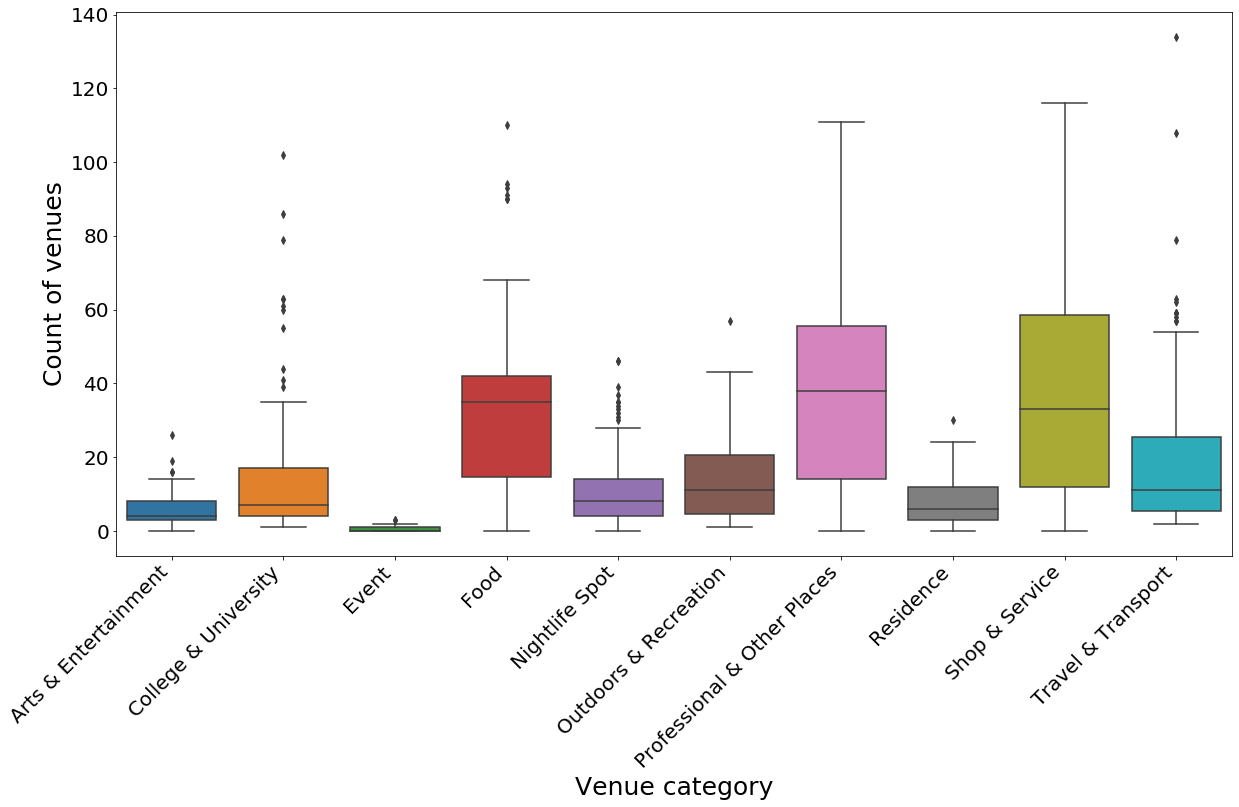

In [68]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = stations_venues_df[[c[0] for c in categories_list]])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

It looks like the most frequent venue categories are Shop&Service, Professional&OtherPlaces, and Food. Event has very little data, so let's discard it from both the dataframe and the list of categories.

In [69]:
stations_venues_df.drop('Event', 1, inplace=True)

In [70]:
categories_list = list(filter(lambda x: x[0] != 'Event', categories_list))

The data preparation phase is nearly complete. Since the range of values among the categories is significant (noticeable from the outliers on the boxplots), we need to normalize the data to minimize the distortion differences in the ranges of values.

#### Data Normalization

Let's normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

Separate the columns to be normalized from the rest of the data :

In [77]:
venues_df = stations_venues_df[[c[0] for c in categories_list]]
venues_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,8,10,90,22,17,67,20,53,7
1,16,16,54,28,39,0,16,91,79
2,1,1,4,1,3,3,3,3,4
3,8,15,27,5,5,42,9,20,4
4,5,6,43,7,5,25,2,62,11


Now normalize each column in the dataframe **venues_df** :

In [78]:
from sklearn.preprocessing import MinMaxScaler

X = venues_df
cluster_dataset = MinMaxScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Place the results into a dataframe, **cluster_df**, and take a quick peek the results :

In [79]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c[0] for c in categories_list]
cluster_df.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.307692,0.089109,0.818182,0.478261,0.285714,0.603604,0.666667,0.456897,0.037879
1,0.615385,0.148515,0.490909,0.608696,0.678571,0.000000,0.533333,0.784483,0.583333
2,0.038462,0.000000,0.036364,0.021739,0.035714,0.027027,0.100000,0.025862,0.015152
3,0.307692,0.138614,0.245455,0.108696,0.071429,0.378378,0.300000,0.172414,0.015152
4,0.192308,0.049505,0.390909,0.152174,0.071429,0.225225,0.066667,0.534483,0.068182


Let's visualize the scaled data :

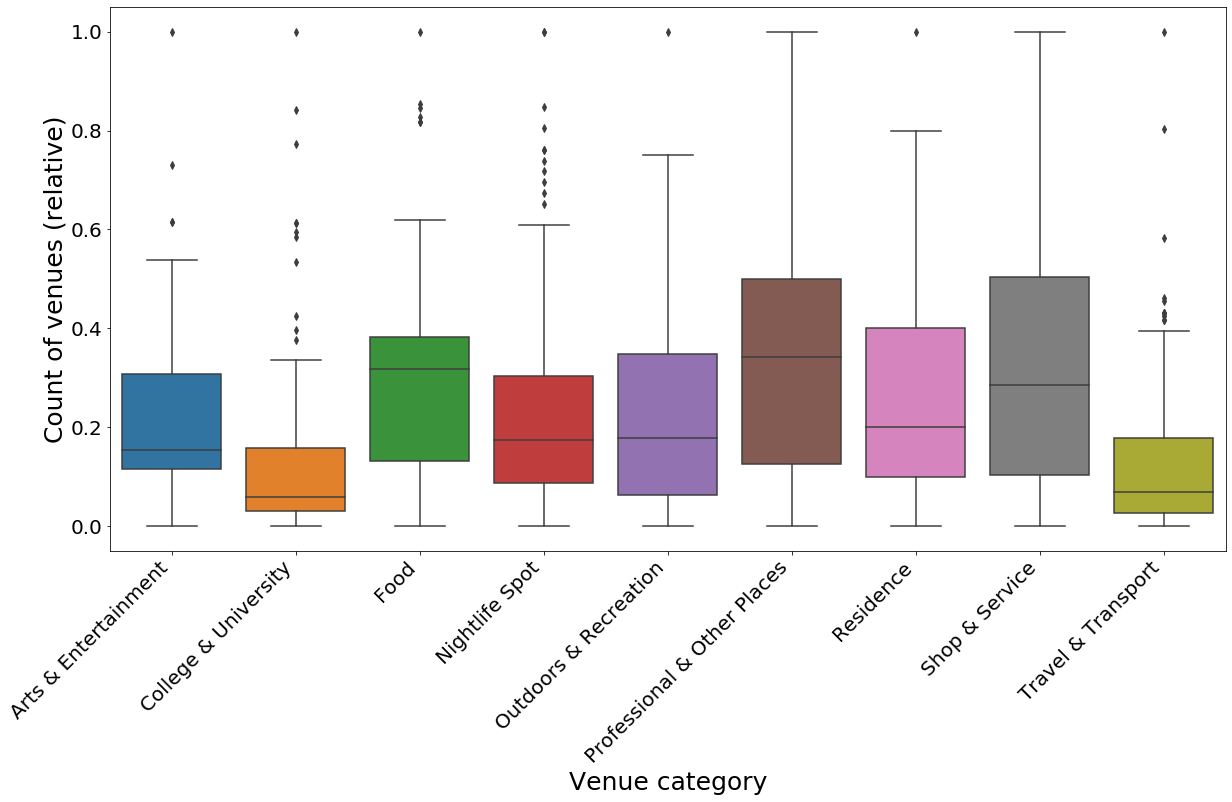

In [80]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = cluster_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Let's save the normalized station venues data into a .csv file :

In [25]:
cluster_df.to_csv('BKK_normalized_metro_venues.csv', index=False)

If you wish to skip the data normalization part, use the code below to read in data from the .csv file :

In [ ]:
'''
#Read already stored CSV
cluster_df = pd.read_csv('BKK_normalized_metro_venues.csv', index_col=None)
cluster_df.head()
'''

We can now start the metro station classification process.

## Methodology

Our classifier will use K-Means Clustering. Using different numbers of clusters, the initial results can be seen below :

  * 2 clusters divided the area into just the downtown central area and the outer city surrounding area
  * 3 clusters yield the most intuitive result consisting of high density areas, medium venue density areas, and low density suburbs
  * 4 or more clusters are difficult to interpret, or need a more in-depth analysis to explain the cluster results

For the scope of this class project, we will use 3 clusters in our analysis.

In [48]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:1, 2:0}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['English Station Name'] = stations_venues_df['English Station Name']

We can use boxplots to view the classified clusters :

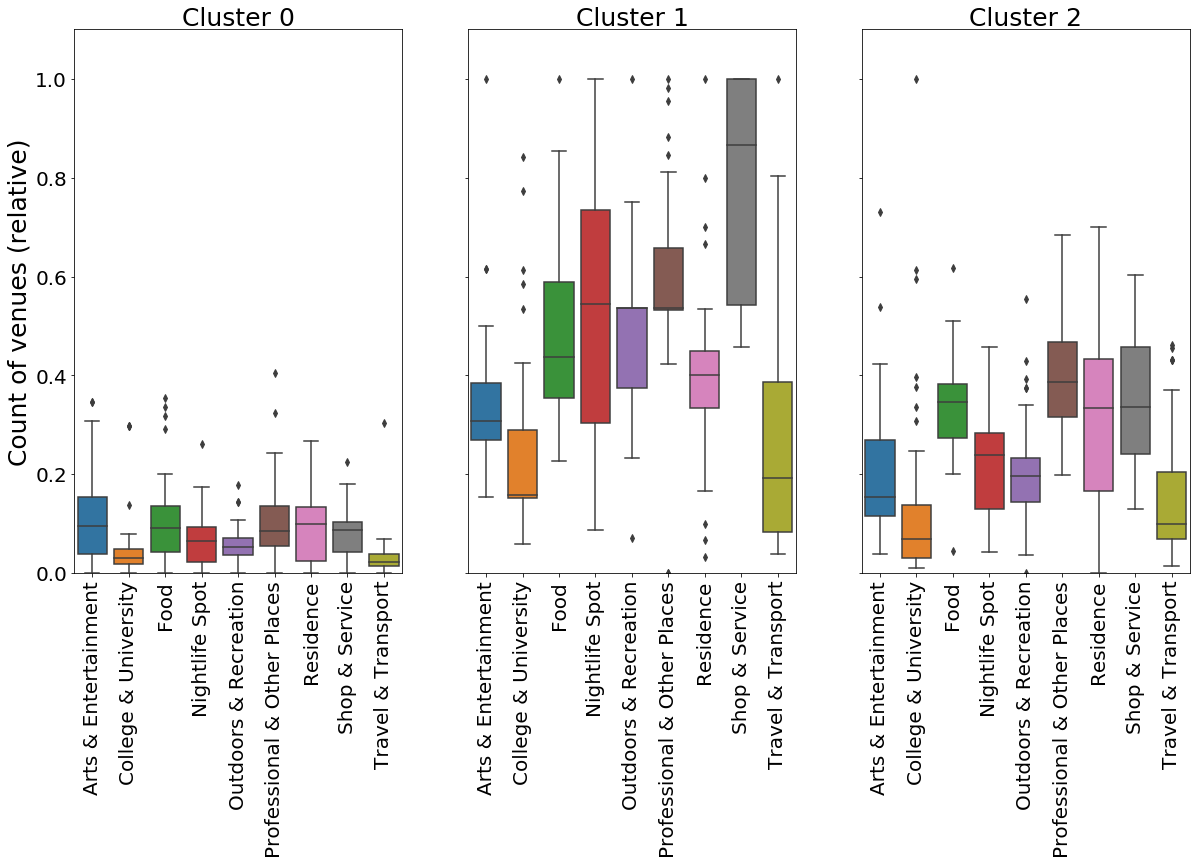

In [49]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

We can draw the clustered locations onto a map of Bangkok. We will use the 3 colors of the Thai national flag for the 3 classified clusters. The clickable popup for each station will show the top 3 venue categories surrounding that area.

In [51]:
stations_clusters_minmax_df['Latitude'] = stations_venues_df['Latitude']
stations_clusters_minmax_df['Longitude'] = stations_venues_df['Longitude']

#create a map of Bangkok with all the metro stations
map_bkk_metro = folium.Map(location=[bkk_longlats['lat'], bkk_longlats['lng']], zoom_start=11)

#add markers
for i, station, lat, lng, cluster in zip(stations_clusters_minmax_df.index,
                                         stations_clusters_minmax_df['English Station Name'],
                                         stations_clusters_minmax_df['Latitude'],
                                         stations_clusters_minmax_df['Longitude'],
                                         stations_clusters_minmax_df['Cluster']):
    latlong = [lat, lng]    
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['red','blue','white']
    #Calculate top 3 categories for each station
    station_series = stations_clusters_minmax_df.iloc[i]
    top_categories_dict = {}
    for cat in categories_list:
        top_categories_dict[cat[0]] = station_series[cat[0]]
    top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
    popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
        station,
        cluster,
        top_categories[0][0],
        "{0:.2f}".format(top_categories[0][1]),
        top_categories[1][0],
        "{0:.2f}".format(top_categories[1][1]),
        top_categories[2][0],
        "{0:.2f}".format(top_categories[2][1]))
    folium.CircleMarker(
        latlong,
        fill=True,
        fill_opacity=0.5,
        popup=folium.Popup(popup, max_width = 300),
        radius=7,
        color=colors[cluster]
    ).add_to(map_bkk_metro)
    
map_bkk_metro

Let's save the map to an HTML file :

In [52]:
map_bkk_metro.save('bkk_metro_map.html')

## Results

We can briefly summarize each of our classified clusters by looking at the boxplot showing the normalized values for the venues nearby each group of stations :

  * Cluster 0 (Red) on average has the least number of venues near its stations, and appears as the lowest density area
  * Cluster 1 (Blue) has the highest number of venues nearby, especially for Shop&Service, Nightlife Spot, and Travel&Transport
  * Cluster 2 (White) has the overall highest number of Residence venues, and is between the other 2 clusters in nearby venue density

After coloring and plotting most of the stations (some locations did not render) on a map of the Bangkok Metropolitan Region, we can see that :

  * Cluster 1 (Blue) most likely has the highest number of people passing by and creating venues and check-ins, as they are in the densely populated areas of the city (offices and department stores i.e. Si Lom station), or in the case of Suvarnabhumi International Airport, a very high volume of daily traffic as a transport hub
  * Cluster 0 (Red) marks stations that are not in areas as developed as in the other 2 clusters, with the average for the Residence category being the highest among all the venue types located nearby
  * Cluster 2 (White) seems to mark stations where there are less nearby venues than those stations in blue, but still quite a high number than when compared to the red stations

Some important stations (i.e. BTS Siam station, BTS & ARL Phaya Thai station) could not be drawn on the map when using the Folium library, however, the final map is still quite informative as stations nearby were rendered and appear to be correctly classified, so for our project's scope (looking at the area as a whole) this is still deemed quite satisfactory.

## Discussion

There are some factors to consider when analyzing the results of this data science project. First, using the Foursquare database to get the number of venues around each station can make our results a bit biased towards the Food and Travel&Transport categories, as these 2 types of locations are the most commented and checked-into places (see the paper at https://www.researchgate.net/publication/261060627_Exploring_venue_popularity_in_Foursquare for more details). The significance of a location or building also is not shown, so some key landmarks or important areas might not be highlighted. However, with the main theme being density and having users being able to click and reveal the top 3 categories of each rendered location on the map, we were able to answer the questions and challenges asked in the beginning of the project.

## Conclusion

We have shown how to use the Google Geocoding API, the Foursquare Places API, and the Python Folium library to retrieve the locations and nearby number of venues around each of Bangkok's metro (BTS, MRT, ARL) stations, and plot most of them onto an interactive map of the Bangkok Metropolitan Region. The data collected can be useful to others in the future in other areas of research, especially if combined with more data from other sources, such as social media feeds or census data.